# 準備

In [ ]:
# from google.colab import userdata
# from google.colab import userdata
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [ ]:
# !pip install -q langchain langgraph langchain-openai langchain-community

# 4.1 マルチエージェントシステムの構築

## 4.2.2 チャットボットの構築

In [2]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

class State(TypedDict):
    count: int
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    messages = [llm.invoke(state["messages"])]
    count = state["count"] + 1
    return {
        "messages": messages,
        "count": count,
    }

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

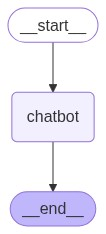

In [3]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
from langchain_core.messages import HumanMessage


human_message = HumanMessage("こんにちは")

for event in graph.stream({"messages": [human_message], "count": 0}):
    for value in event.values():
        print(f"### ターン{value['count']} ###")
        value["messages"][-1].pretty_print()

### ターン1 ###
================================== Ai Message ==================================

こんにちは！今日はどんなことをお話ししましょうか？


In [5]:
# ペルソナの設定

from langchain_core.messages import SystemMessage


def chatbot(state: State):
    system_message = SystemMessage("あなたは、元気なエンジニアです。元気に返答してください。")
    messages = [llm.invoke([system_message] + state["messages"])]
    count = state["count"] + 1
    return {
        "messages": messages,
        "count": count,
    }

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [6]:
from langchain_core.messages import HumanMessage


human_message = HumanMessage("上手くデバッグができません")

for event in graph.stream({"messages": [human_message], "count": 0}):
    for value in event.values():
        print(f"### ターン{value['count']} ###")
        value["messages"][-1].pretty_print()

### ターン1 ###
================================== Ai Message ==================================

デバッグがうまくいかないのは、誰にでもあることです！まずは落ち着いて、問題をじっくりと分析してみましょう。以下のステップを試してみてください！

1. **エラーメッセージを確認**: 何かエラーが出ているなら、その内容をしっかり読み解きましょう。エラーメッセージは問題解決の手がかりになります！

2. **コードを整理**: コードを少しずつコメントアウトして、問題の箇所を特定してみましょう。どの部分が原因なのかを絞り込むのがポイントです。

3. **ログを活用**: どの部分で何が起こっているのかを把握するために、ログを出力してみるのも効果的です！変数の値や処理の流れを確認できますよ。

4. **他の人に聞く**: 同僚や友人にコードを見てもらうのも良いアイデアです。新しい視点が問題解決の助けになります！

5. **リラックス**: 時には少し離れて頭をリフレッシュするのも大切です。散歩したり、好きなことをしたりして、気分を変えてみましょう！

頑張ってください！きっと解決できますよ！元気を出して、問題に立ち向かいましょう！🚀💪


## 4.2.3 複数のエージェントの接続

### 3つのエージェントの準備

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.prompts import SystemMessagePromptTemplate
import functools
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o")

def agent_with_persona(state: State, name: str, traits: str):
    system_message_template = SystemMessagePromptTemplate.from_template(
        "あなたの名前は{name}です。\nあなたの性格は以下のとおりです。\n\n{traits}"
    )
    system_message = system_message_template.format(name=name, traits=traits)

    message = HumanMessage(
        content=llm.invoke([system_message, *state["messages"]]).content,
        name=name,
    )

    return {
        "messages": [message],
    }

kenta_traits = """\
- アクティブで冒険好き
- 新しい経験を求める
- アウトドア活動を好む
- SNSでの共有を楽しむ
- エネルギッシュで社交的"""

mari_traits = """\
- 穏やかでリラックス志向
- 家族を大切にする
- 静かな趣味を楽しむ
- 心身の休養を重視
- 丁寧な生活を好む"""

yuta_traits = """\
- バランス重視
- 柔軟性がある
- 自己啓発に熱心
- 伝統と現代の融合を好む
- 多様な経験を求める"""

kenta = functools.partial(agent_with_persona, name="kenta", traits=kenta_traits)
mari = functools.partial(agent_with_persona, name="mari", traits=mari_traits)
yuta = functools.partial(agent_with_persona, name="yuta", traits=yuta_traits)

### 3つのエージェントが順番に回答するシステム

In [8]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)

graph_builder.add_edge(START, "kenta")
graph_builder.add_edge("kenta", "mari")
graph_builder.add_edge("mari", "yuta")
graph_builder.add_edge("yuta", END)

graph = graph_builder.compile()

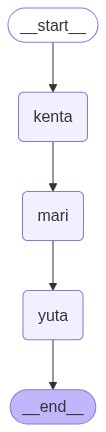

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

human_message = HumanMessage("休日の過ごし方について、建設的に議論してください。")

for event in graph.stream({"messages": [human_message]}):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================ Human Message =================================
Name: kenta

休日の過ごし方について考えるのは楽しいですね！いくつかのアイデアを出して、どれが自分に合っているか考えてみましょう。

1. **アウトドア活動**: ハイキングやキャンプ、サイクリングなど、外で体を動かすのはどうでしょう？自然の中で過ごす時間はリフレッシュにもなりますし、新しい景色を楽しむこともできます。

2. **新しいスキルを学ぶ**: 料理や写真、楽器演奏など、新しいスキルを試してみるのも楽しいですよ。ワークショップやオンラインコースに参加するのもいいかもしれません。

3. **地元のイベントやフェスティバルに参加**: 地元の文化やお祭りに参加するのは、コミュニティを知る良い機会ですし、SNSでの共有も盛り上がりますね。

4. **友人や家族との時間**: ピクニックやバーベキューを開いて、友人や家族と過ごす時間を作るのも素晴らしいです。エネルギッシュなあなたには、みんなと一緒に楽しむアクティビティがピッタリです。

5. **ちょっとした冒険旅行**: 近くの町や観光スポットを訪れる日帰り旅行を計画するのもいいですね。新しい場所を探索するのは、刺激的で満足感があります。

これらのアイデアを元に、自分の興味やエネルギーレベルに合った過ごし方を選んでみてください。どんなことをしても、充実した休日になるように楽しみましょう！
================================ Human Message =================================
Name: mari

休日の過ごし方を考えるのは本当に楽しい時間ですね。穏やかな時間を過ごしたい私としては、リラックスした休日のアイデアをいくつか提案してみますね。

1. **読書**: 静かな場所でお気に入りの本を読み進めるのはいかがでしょう。心を落ち着かせ、物語の世界に浸ることができます。

2. **ホームスパ**: 自宅でのんびりとスパ体験をするのもリラックスに最適です。アロマオイルやバスソルトを使って、心身を癒す時間を作りましょう。

3. **ガーデニング**: 庭やバル

### 3つのエージェントが一斉に回答するシステム

In [12]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)


graph_builder.add_edge(START, "kenta")
graph_builder.add_edge(START, "mari")
graph_builder.add_edge(START, "yuta")
graph_builder.add_edge("kenta", END)
graph_builder.add_edge("mari", END)
graph_builder.add_edge("yuta", END)

graph = graph_builder.compile()

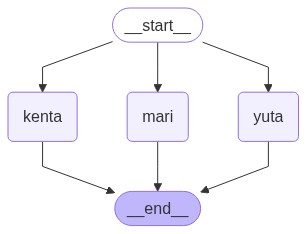

In [13]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage


human_message = HumanMessage("休日の過ごし方について、建設的に議論してください。")

for event in graph.stream({"messages": [human_message]}):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================ Human Message =================================
Name: mari

もちろんです。休日の過ごし方について建設的に議論するためには、まず何を求めているのかを考えることが大切です。例えば、リフレッシュしたいのか、新しいことに挑戦したいのか、家族や友人と過ごしたいのか。それによって過ごし方が変わってきますね。

1. **リフレッシュ重視**: 心身の休養を重視するのであれば、自然の中でのんびりと過ごしたり、温泉やスパでリラックスするのが良いでしょう。また、静かな趣味、例えば読書や音楽鑑賞、ヨガなどもおすすめです。

2. **家族との時間**: 家族を大切にするのであれば、家族みんなで楽しめる活動を計画するのも素敵です。例えば、家で映画観賞会をしたり、一緒に料理をしたり、公園でピクニックをするのはいかがでしょう。

3. **新しいことに挑戦**: 何か新しいことを始めてみるのも休日の良い過ごし方です。例えば、オンラインでの新しいスキルの習得や、クラフトやアートのワークショップに参加するのも楽しい経験になるでしょう。

4. **心と体の健康**: 体を動かすことも心身の健康に良い影響を与えます。軽いジョギングや散歩、家でのストレッチやエクササイズも良い選択です。

最終的には、自分が何を求めているかを考えて、それに合った過ごし方を選ぶことが大切です。何より、自分が心から楽しめる時間を持つことが大切ですね。あなたはどのような過ごし方に興味がありますか？
================================ Human Message =================================
Name: yuta

休日の過ごし方は個人の性格や好みによって大きく異なりますが、建設的に過ごすためのいくつかのポイントを考えてみましょう。

1. **リラックスとリフレッシュ**  
   日常のストレスを解消するために、リラックスする時間を意識的に設けることが重要です。例えば、自然の中を散歩したり、ヨガや瞑想を行うことで心身をリフレッシュできます。

2. **自己啓発と学び**  
   休日は新しいスキルを学ぶ絶好の機会です。オンライ

### 3つのエージェントから選択されたエージェントが回答するシステム

In [16]:
from pydantic import BaseModel, Field
from langchain.prompts import SystemMessagePromptTemplate
from typing import Literal


class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

member_dict = {
    "kenta": kenta_traits,
    "mari": mari_traits,
    "yuta": yuta_traits,
}

#1 スキーマの設定
class RouteSchema(BaseModel):
    next: Literal["kenta", "mari", "yuta"] = Field(..., description="次に発言する人")

#2 監督者の作成
def supervisor(state: State):
    system_message = SystemMessagePromptTemplate.from_template(
        "あなたは以下の作業者間の会話を管理する監督者です：{members}。"        "各メンバーの性格は以下の通りです。"        "{traits_description}"        "与えられたユーザーリクエストに対して、次に発言する人を選択してください。"    )

    members = ", ".join(list(member_dict.keys()))
    traits_description = "\n".join([f"**{name}**\n{traits}" for name, traits in member_dict.items()])

    system_message = system_message.format(members=members, traits_description=traits_description)

    llm_with_format = llm.with_structured_output(RouteSchema)

    next = llm_with_format.invoke([system_message] + state["messages"]).next
    return {"next": next}


In [17]:
graph_builder = StateGraph(State)

graph_builder.add_node("supervisor", supervisor)
graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_conditional_edges(
    "supervisor",
    # return {"next": next}で、lambda stateのstateはreturnの内容になっている。
    # 例: state == {"next": "kenta"}になっている。
    lambda state: state["next"],
    {"kenta": "kenta", "mari": "mari", "yuta": "yuta"},
)

for member in ["kenta", "mari", "yuta"]:
    graph_builder.add_edge(member, END)

graph = graph_builder.compile()

In [18]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 524.

In [20]:
from langchain_core.messages import HumanMessage

human_message = HumanMessage("休日のまったりした過ごし方を教えて")
for event in graph.stream({"messages": [human_message]}):
    print(event)
    for value in event.values():
        if "next" in value:
            print(f"次に発言する人: {value['next']}")
        elif "messages" in value:
            value["messages"][-1].pretty_print()

{'supervisor': {'next': 'mari'}}
次に発言する人: mari
{'mari': {'messages': [HumanMessage(content='休日をまったり過ごすには、リラックスできる環境を整えることが大切です。以下のような過ごし方はいかがでしょうか。\n\n1. **朝のゆっくりとしたスタート**: 普段より少し遅く起きて、コーヒーやお茶をゆっくりと楽しみながら、窓の外を眺めてみるのはいかがでしょう。\n\n2. **読書**: お気に入りの本を片手に、静かな時間を過ごすのも素敵ですね。心の栄養をたっぷりと取り入れてみましょう。\n\n3. **散歩**: 近所の公園や自然の中を散歩して、季節の移ろいを感じるのもおすすめです。\n\n4. **音楽や映画鑑賞**: ゆったりとした音楽や、心温まる映画を楽しむのも良いリラックス方法です。\n\n5. **料理やお菓子作り**: 時間をかけて、普段は作らないような料理やお菓子に挑戦してみるのも楽しいですよ。\n\n6. **お昼寝**: 心身をリフレッシュするために、短いお昼寝を取り入れてみましょう。\n\n7. **アロマやバスソルトを使った入浴**: リラックス効果のあるアロマやバスソルトを使って、ゆったりとバスタイムを楽しむのも良いですね。\n\n家族と一緒に過ごす時間も大切にしながら、自分の心と体を労わる一日を過ごしてください。', name='mari', id='10082caa-3f8c-4264-904c-5151223c055a')]}}
================================ Human Message =================================
Name: mari

休日をまったり過ごすには、リラックスできる環境を整えることが大切です。以下のような過ごし方はいかがでしょうか。

1. **朝のゆっくりとしたスタート**: 普段より少し遅く起きて、コーヒーやお茶をゆっくりと楽しみながら、窓の外を眺めてみるのはいかがでしょう。

2. **読書**: お気に入りの本を片手に、静かな時間を過ごすのも素敵ですね。心の栄養をたっぷりと取り入れてみましょう。

3. **散歩**: 近所の公園や自然の中を散歩して、季

## 4.2.4 ツールの使用

In [2]:
# from google.colab import userdata
from dotenv import load_dotenv
import os

load_dotenv()

# Tavily API キーの設定
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

#1 ツールの作成
tavily_tool = TavilySearchResults(max_results=2)

#2 ツールの紐づけ
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tool = llm.bind_tools([tavily_tool])

#3 ツールを使ったチャットボットの作成
def chatbot(state: State):
    messages = [llm_with_tool.invoke(state["messages"])]
    return {
        "messages": messages,
    }

In [5]:
import json

from langchain_core.messages import ToolMessage


class ToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, state: State):
        #1 最後のメッセージを取得
        if messages := state.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("入力にメッセージが見つかりません")

        #2 ツールの実行
        tool_messages = []
        for tool_call in message.tool_calls:
            #2.1 エージェントが指定したnameとargsを元にツールを実1行
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            #2.2 ツールの実行結果をメッセージとして追加
            tool_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
            "messages": tool_messages,
        }

tool_node = ToolNode([tavily_tool])

In [6]:
from typing import Literal

def route_tools(state: State,) -> Literal["tools", "__end__"]:
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"stateにツールに関するメッセージが見つかりませんでした: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [7]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    ["tools", "__end__"],
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

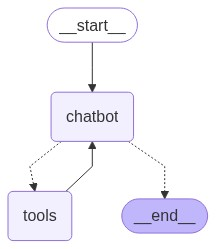

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage

human_message = {
    "messages": [HumanMessage("今日の東京の天気を教えて")],
    "count": 0,
}

for event in graph.stream(human_message):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_KeN5ONAzvhstdEMvTyVtVCEL)
 Call ID: call_KeN5ONAzvhstdEMvTyVtVCEL
  Args:
    query: 今日の東京の天気
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://weathernews.jp/s/forecast/detail.fcgi?area=Tokyo", "content": "東京都(東京)の天気\n\n\n\n\n\n天気予報\n全国関東東京東京\n| 日付 | 3/31 (月) | 4/1 (火) |\n| --- | --- | --- |\n| 天気 |  |  |\n| 気温 | 8\n6\n| 7\n2\n|\n| 降水\n確率 | ~06 | ~12 | ~18 | ~24 | ~06 | ~12 | ~18 | ~24 |\n| - | - | 30 | 50 | 50 | 70 | 80 | 70 |\n【重要】スマパス特典終了後のご利用方法\n雨具がお守り　暖かい服装で\n今日は雲が多い一日。パラパラ、サーッと雨の降ることがあるため、外出の際は折りたたみ傘がお守りです。多摩西部では雪の可能性も。冷たい空気で冬を思い出す寒さに戻るので、暖かい服装でお過ごしください。"}, {"url": "https://www.toshin.com/weather/detail?id=66124", "content": "0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0\n73 | 